In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import xgboost

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import font_manager


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train_df = pd.read_csv('./split/train.csv')

In [3]:
test_df = pd.read_csv('./split/test.csv')

In [4]:
from pycaret.classification import *

In [5]:
clf = setup(data = train_df, 
             target = 'MOCA_Grade',
             preprocess = False,
             test_data= test_df,
             train_size=1.0,
             index=False)


,Description,Value
0,Session id,8583
1,Target,MOCA_Grade
2,Target type,Binary
3,Original data shape,"(651, 28)"
4,Transformed data shape,"(651, 28)"
5,Transformed train set shape,"(514, 28)"
6,Transformed test set shape,"(137, 28)"
7,Numeric features,27


In [6]:
best = compare_models(fold=10,n_select=5,exclude=['dummy','qda'],sort='AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:02:53
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9357,0.9877,0.9400,0.9308,0.9340,0.8713,0.8739,0.0340
rf,Random Forest Classifier,0.9396,0.9847,0.9600,0.9219,0.9397,0.8792,0.8815,0.0450
catboost,CatBoost Classifier,0.9317,0.9827,0.9680,0.9028,0.9335,0.8637,0.8673,1.4690
lightgbm,Light Gradient Boosting Machine,0.9221,0.9754,0.9560,0.8945,0.9229,0.8444,0.8489,0.0640
xgboost,Extreme Gradient Boosting,0.9143,0.9745,0.9320,0.9005,0.9137,0.8286,0.8332,0.0260
gbc,Gradient Boosting Classifier,0.9124,0.9698,0.9362,0.8943,0.9129,0.8248,0.8290,0.0450
ridge,Ridge Classifier,0.8560,0.9448,0.8682,0.8466,0.8545,0.7120,0.7172,0.0060
lda,Linear Discriminant Analysis,0.8560,0.9445,0.8682,0.8455,0.8543,0.7119,0.7164,0.0070
lr,Logistic Regression,0.8618,0.9413,0.8603,0.8622,0.8583,0.7235,0.7288,0.7320
knn,K Neighbors Classifier,0.8325,0.9342,0.9483,0.7698,0.8475,0.6671,0.6908,0.3670


# 未调参 前5个model

In [7]:
et = create_model('et')
rf = create_model('rf')
catboost = create_model('catboost')
lightgbm = create_model('lightgbm')
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8846,0.9548,0.8400,0.9130,0.8750,0.7682,0.7705
1,0.9423,0.9748,0.9200,0.9583,0.9388,0.8843,0.8849
2,0.9615,0.9985,1.0000,0.9259,0.9615,0.9232,0.9259
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9216,0.9846,0.9600,0.8889,0.9231,0.8433,0.8459
5,0.9020,0.9892,0.8800,0.9167,0.8980,0.8037,0.8043
6,0.9216,0.9900,1.0000,0.8621,0.9259,0.8436,0.8541
7,0.9608,1.0000,1.0000,0.9259,0.9615,0.9217,0.9245
8,0.9020,0.9854,0.8800,0.9167,0.8980,0.8037,0.8043


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.9719,0.9600,0.9231,0.9412,0.8846,0.8853
1,0.9231,0.9726,0.8800,0.9565,0.9167,0.8455,0.8480
2,0.9615,0.9941,1.0000,0.9259,0.9615,0.9232,0.9259
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8627,0.9677,0.9200,0.8214,0.8679,0.7260,0.7311
5,0.9608,0.9938,1.0000,0.9259,0.9615,0.9217,0.9245
6,0.9216,0.9785,0.9600,0.8889,0.9231,0.8433,0.8459
7,0.9020,0.9785,0.9600,0.8571,0.9057,0.8043,0.8099
8,0.9804,0.9985,1.0000,0.9615,0.9804,0.9608,0.9615


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9038,0.9467,0.9200,0.8846,0.9020,0.8077,0.8083
1,0.9423,0.9644,0.9200,0.9583,0.9388,0.8843,0.8849
2,0.9615,0.9970,1.0000,0.9259,0.9615,0.9232,0.9259
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8627,0.9738,0.9200,0.8214,0.8679,0.7260,0.7311
5,0.9608,1.0000,1.0000,0.9259,0.9615,0.9217,0.9245
6,0.9412,0.9846,1.0000,0.8929,0.9434,0.8826,0.8887
7,0.8235,0.9677,0.9200,0.7667,0.8364,0.6483,0.6610
8,0.9608,1.0000,1.0000,0.9259,0.9615,0.9217,0.9245


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9038,0.9081,0.9200,0.8846,0.9020,0.8077,0.8083
1,0.8846,0.9689,0.8400,0.9130,0.8750,0.7682,0.7705
2,0.9231,0.9911,0.9600,0.8889,0.9231,0.8464,0.8489
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9020,0.9723,1.0000,0.8333,0.9091,0.8046,0.8204
5,0.9412,0.9800,1.0000,0.8929,0.9434,0.8826,0.8887
6,0.9412,0.9985,1.0000,0.8929,0.9434,0.8826,0.8887
7,0.8431,0.9462,0.9200,0.7931,0.8519,0.6871,0.6957
8,0.9608,1.0000,1.0000,0.9259,0.9615,0.9217,0.9245


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8654,0.9304,0.8400,0.8750,0.8571,0.7300,0.7305
1,0.9038,0.9570,0.8400,0.9545,0.8936,0.8065,0.8120
2,0.9423,0.9941,0.9600,0.9231,0.9412,0.8846,0.8853
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8824,0.9708,0.9600,0.8276,0.8889,0.7653,0.7749
5,0.9216,0.9800,1.0000,0.8621,0.9259,0.8436,0.8541
6,0.9216,0.9815,0.9600,0.8889,0.9231,0.8433,0.8459
7,0.8431,0.9508,0.9200,0.7931,0.8519,0.6871,0.6957
8,0.9608,0.9938,1.0000,0.9259,0.9615,0.9217,0.9245


# 调参后的model

In [127]:
tuned_et = tune_model(et, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8077,0.9141,0.7200,0.8571,0.7826,0.6125,0.6200
1,0.8654,0.9452,0.8000,0.9091,0.8511,0.7292,0.7341
2,0.9038,0.9541,0.9600,0.8571,0.9057,0.8083,0.8137
3,0.9808,1.0000,0.9615,1.0000,0.9804,0.9615,0.9623
4,0.8431,0.9338,0.7600,0.9048,0.8261,0.6852,0.6938
5,0.8431,0.9523,0.8000,0.8696,0.8333,0.6857,0.6878
6,0.8627,0.9123,0.8800,0.8462,0.8627,0.7256,0.7262
7,0.8431,0.9938,1.0000,0.7576,0.8621,0.6881,0.7242
8,0.8431,0.9508,0.8400,0.8400,0.8400,0.6862,0.6862


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [128]:
tuned_rf = tune_model(rf, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8654,0.9437,0.8400,0.8750,0.8571,0.7300,0.7305
1,0.9231,0.9600,0.9200,0.9200,0.9200,0.8459,0.8459
2,0.9231,0.9911,0.9200,0.9200,0.9200,0.8459,0.8459
3,0.9808,1.0000,0.9615,1.0000,0.9804,0.9615,0.9623
4,0.8235,0.9385,0.8000,0.8333,0.8163,0.6467,0.6472
5,0.9608,0.9754,1.0000,0.9259,0.9615,0.9217,0.9245
6,0.8824,0.9508,0.8800,0.8800,0.8800,0.7646,0.7646
7,0.8627,0.9631,0.9200,0.8214,0.8679,0.7260,0.7311
8,0.9608,0.9923,0.9600,0.9600,0.9600,0.9215,0.9215


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [129]:
tuned_catboost = tune_model(catboost, optimize = 'AUC')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [130]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8462,0.8963,0.8000,0.8696,0.8333,0.6909,0.6930
1,0.8077,0.9185,0.6800,0.8947,0.7727,0.6114,0.6287
2,0.8462,0.9437,0.8000,0.8696,0.8333,0.6909,0.6930
3,0.9808,0.9970,0.9615,1.0000,0.9804,0.9615,0.9623
4,0.8431,0.9169,0.8000,0.8696,0.8333,0.6857,0.6878
5,0.9020,0.9646,0.9600,0.8571,0.9057,0.8043,0.8099
6,0.8627,0.9477,0.8400,0.8750,0.8571,0.7252,0.7257
7,0.8235,0.9031,0.9200,0.7667,0.8364,0.6483,0.6610
8,0.9412,0.9923,0.9600,0.9231,0.9412,0.8824,0.8831


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [131]:
tuned_xgboost = tune_model(xgboost, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8269,0.8963,0.8400,0.8077,0.8235,0.6538,0.6543
1,0.9615,0.9733,0.9600,0.9600,0.9600,0.9230,0.9230
2,0.9038,0.9911,0.9600,0.8571,0.9057,0.8083,0.8137
3,0.9808,1.0000,1.0000,0.9630,0.9811,0.9615,0.9623
4,0.8824,0.9723,0.9600,0.8276,0.8889,0.7653,0.7749
5,0.9412,0.9969,1.0000,0.8929,0.9434,0.8826,0.8887
6,0.8824,0.9862,1.0000,0.8065,0.8929,0.7657,0.7876
7,0.7843,0.9600,1.0000,0.6944,0.8197,0.5721,0.6330
8,0.9412,1.0000,1.0000,0.8929,0.9434,0.8826,0.8887


Fitting 10 folds for each of 10 candidates, totalling 100 fits


# 测试集预测性能

In [9]:
pred_et=predict_model(tuned_et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8686,0.9167,0.5833,0.6364,0.6087,0.5299,0.5307


In [12]:
pred_rf=predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8832,0.9524,0.7917,0.6333,0.7037,0.6321,0.6382


In [13]:
pred_catboost=predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8686,0.9495,0.8333,0.5882,0.6897,0.6094,0.6243


In [17]:
pred_lightgbm=predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8686,0.9288,0.7917,0.5938,0.6786,0.5981,0.6079


In [45]:
pred_xgboost=predict_model(tuned_xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8613,0.9355,0.9167,0.5641,0.6984,0.6149,0.6454


# 集成模型

## stacking

In [52]:
stack_model = stack_models(estimator_list = best, meta_model = tuned_catboost,optimize = 'AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:33:47
Status,. . . . . . . . . . . . . . . . . .,Compiling Estimators
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9038,0.9600,0.8800,0.9167,0.8980,0.8071,0.8077
1,0.9231,0.9689,0.8800,0.9565,0.9167,0.8455,0.8480
2,0.9615,0.9956,0.9600,0.9600,0.9600,0.9230,0.9230
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9216,0.9831,0.9600,0.8889,0.9231,0.8433,0.8459
5,0.9020,0.9908,0.8400,0.9545,0.8936,0.8034,0.8090
6,0.9412,0.9923,1.0000,0.8929,0.9434,0.8826,0.8887
7,0.9412,0.9969,1.0000,0.8929,0.9434,0.8826,0.8887
8,0.9412,0.9938,0.8800,1.0000,0.9362,0.8820,0.8882


In [54]:
pred_stack=predict_model(stack_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8832,0.9384,0.6667,0.6667,0.6667,0.5959,0.5959


In [ ]:
cali_model = calibrate_model(stack_model)

# 绘图

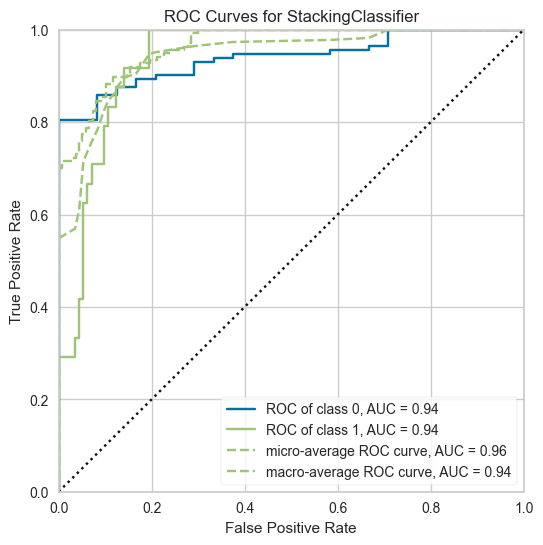

In [93]:
plt.figure(figsize=(6,6),dpi=100)
plot_model(stack_model, plot = 'auc')

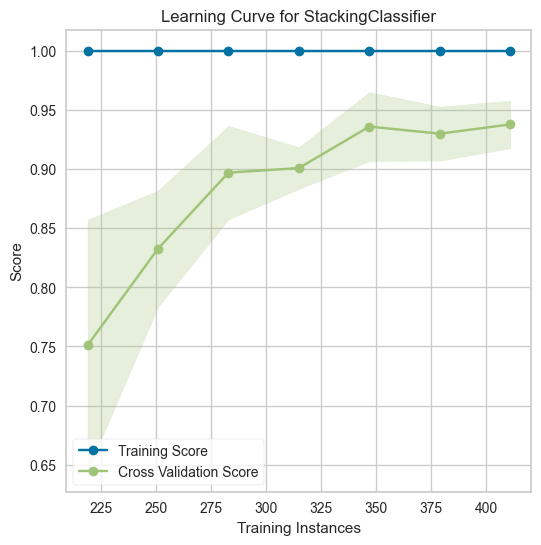

In [96]:
plt.figure(figsize=(8,6),dpi=100)
plot_model(stack_model, plot = 'learning')

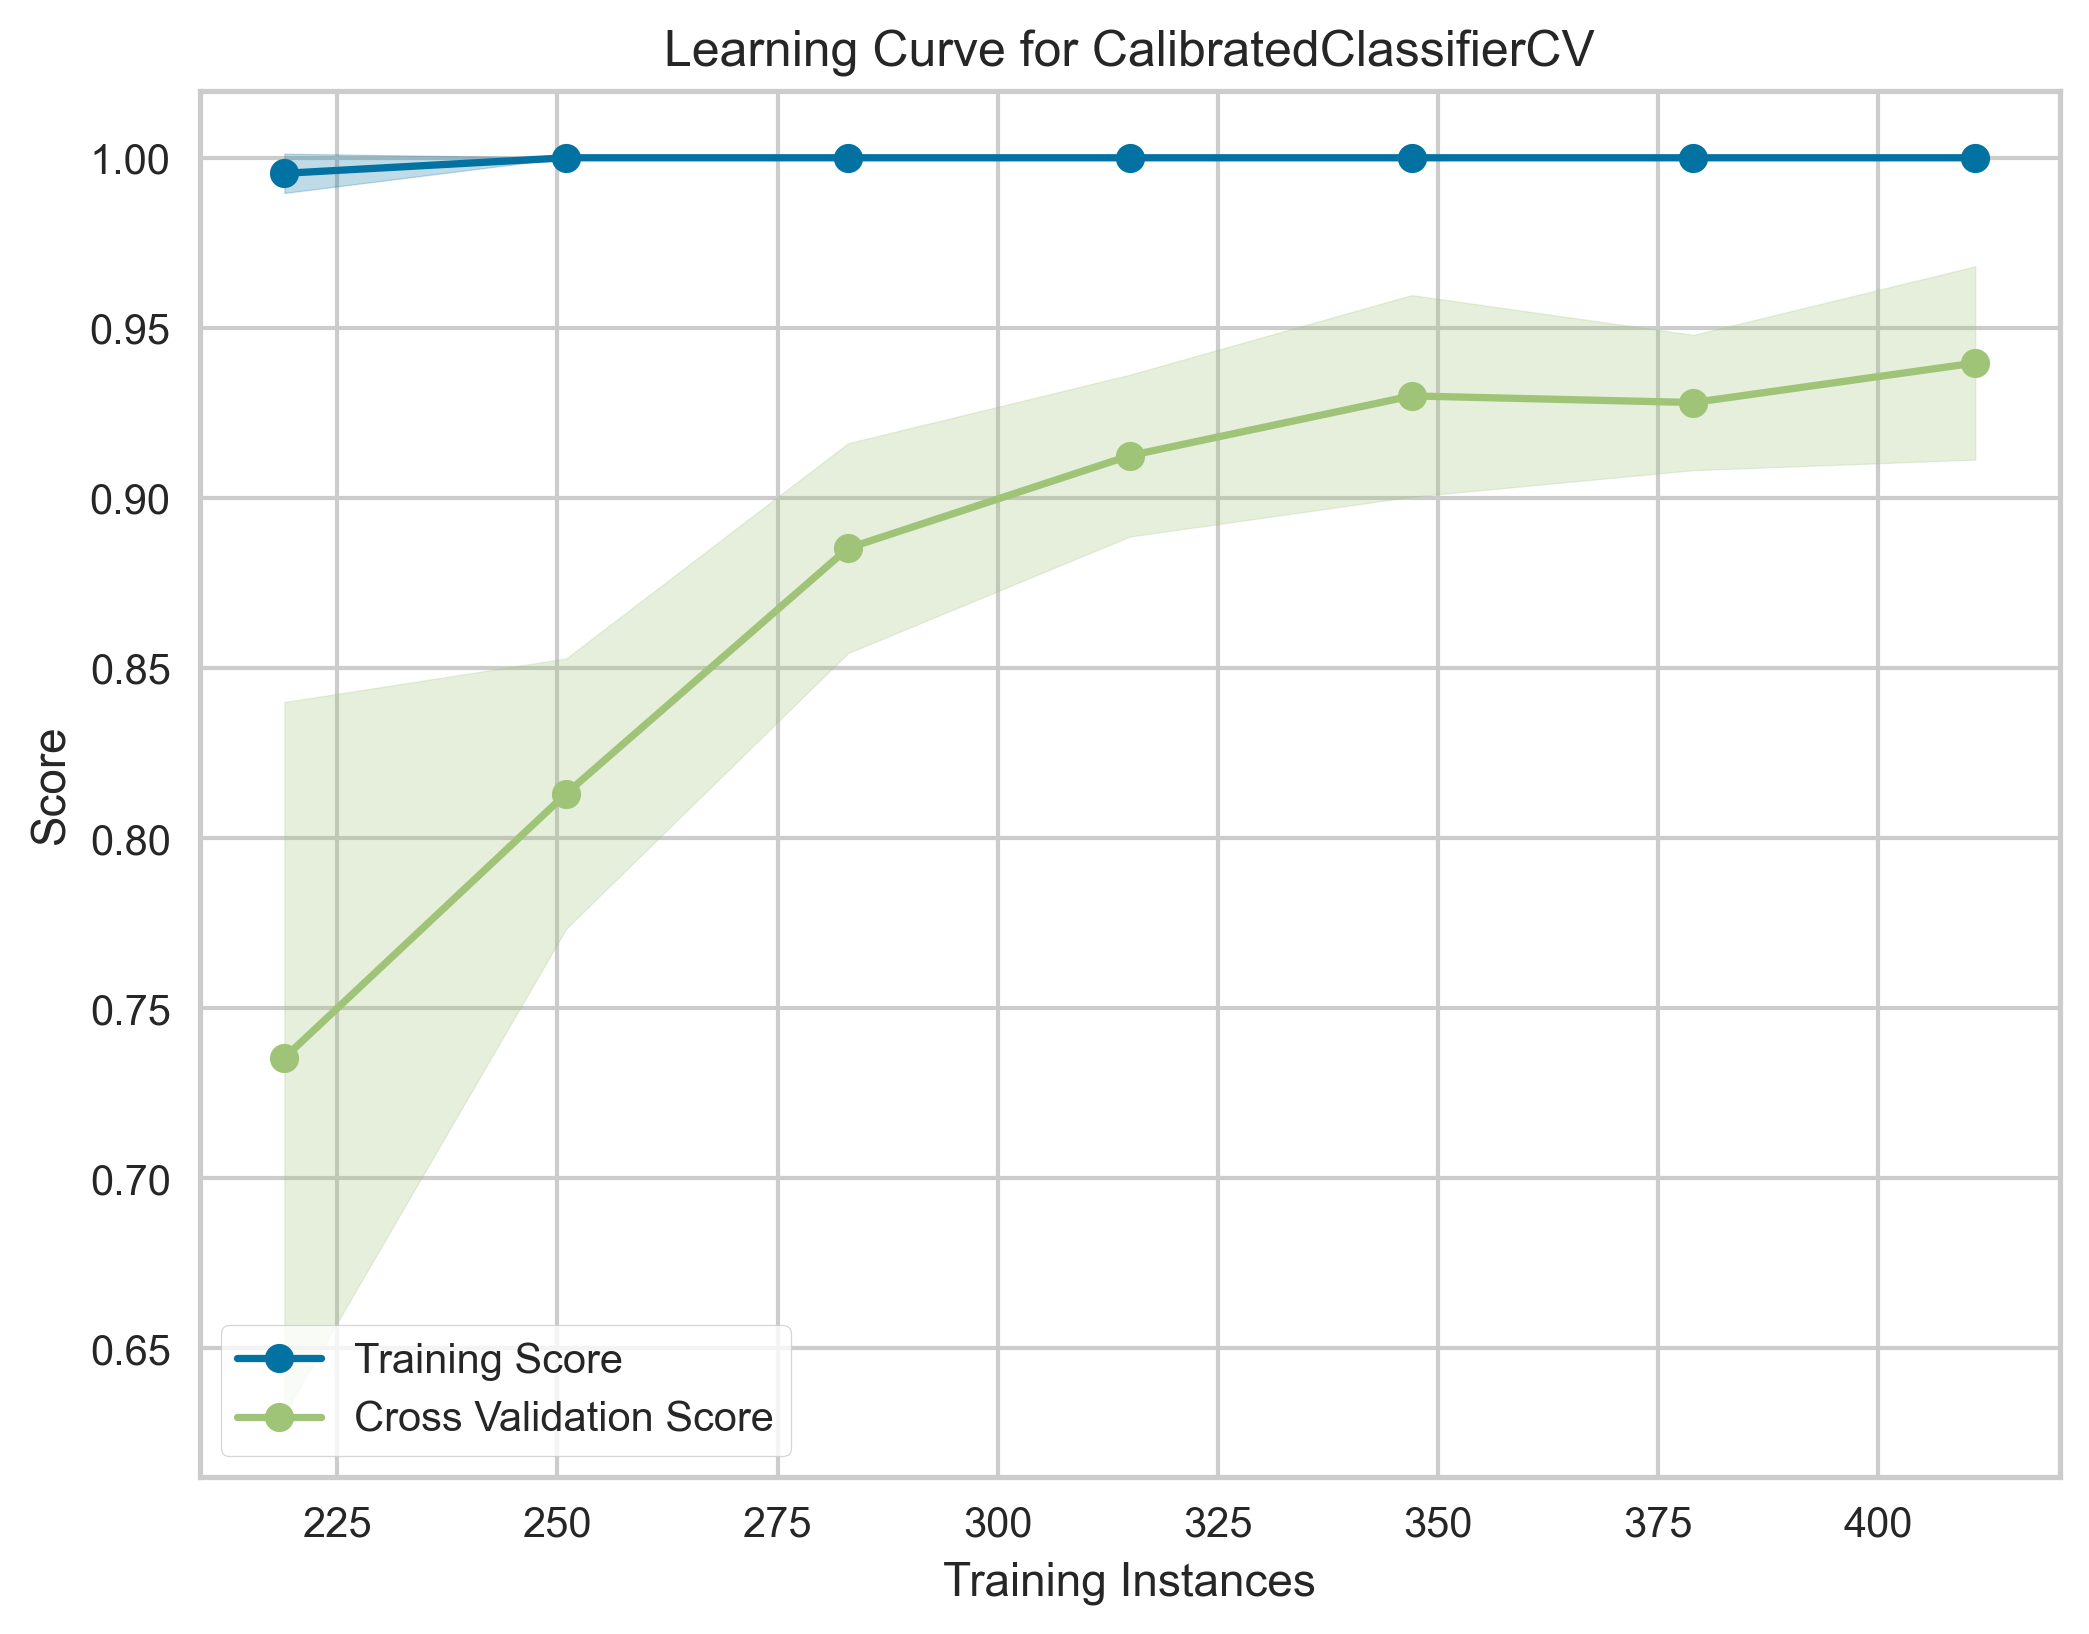

In [321]:
plt.figure(figsize=(8,6),dpi=300)
plot_model(cali_model, plot = 'learning')

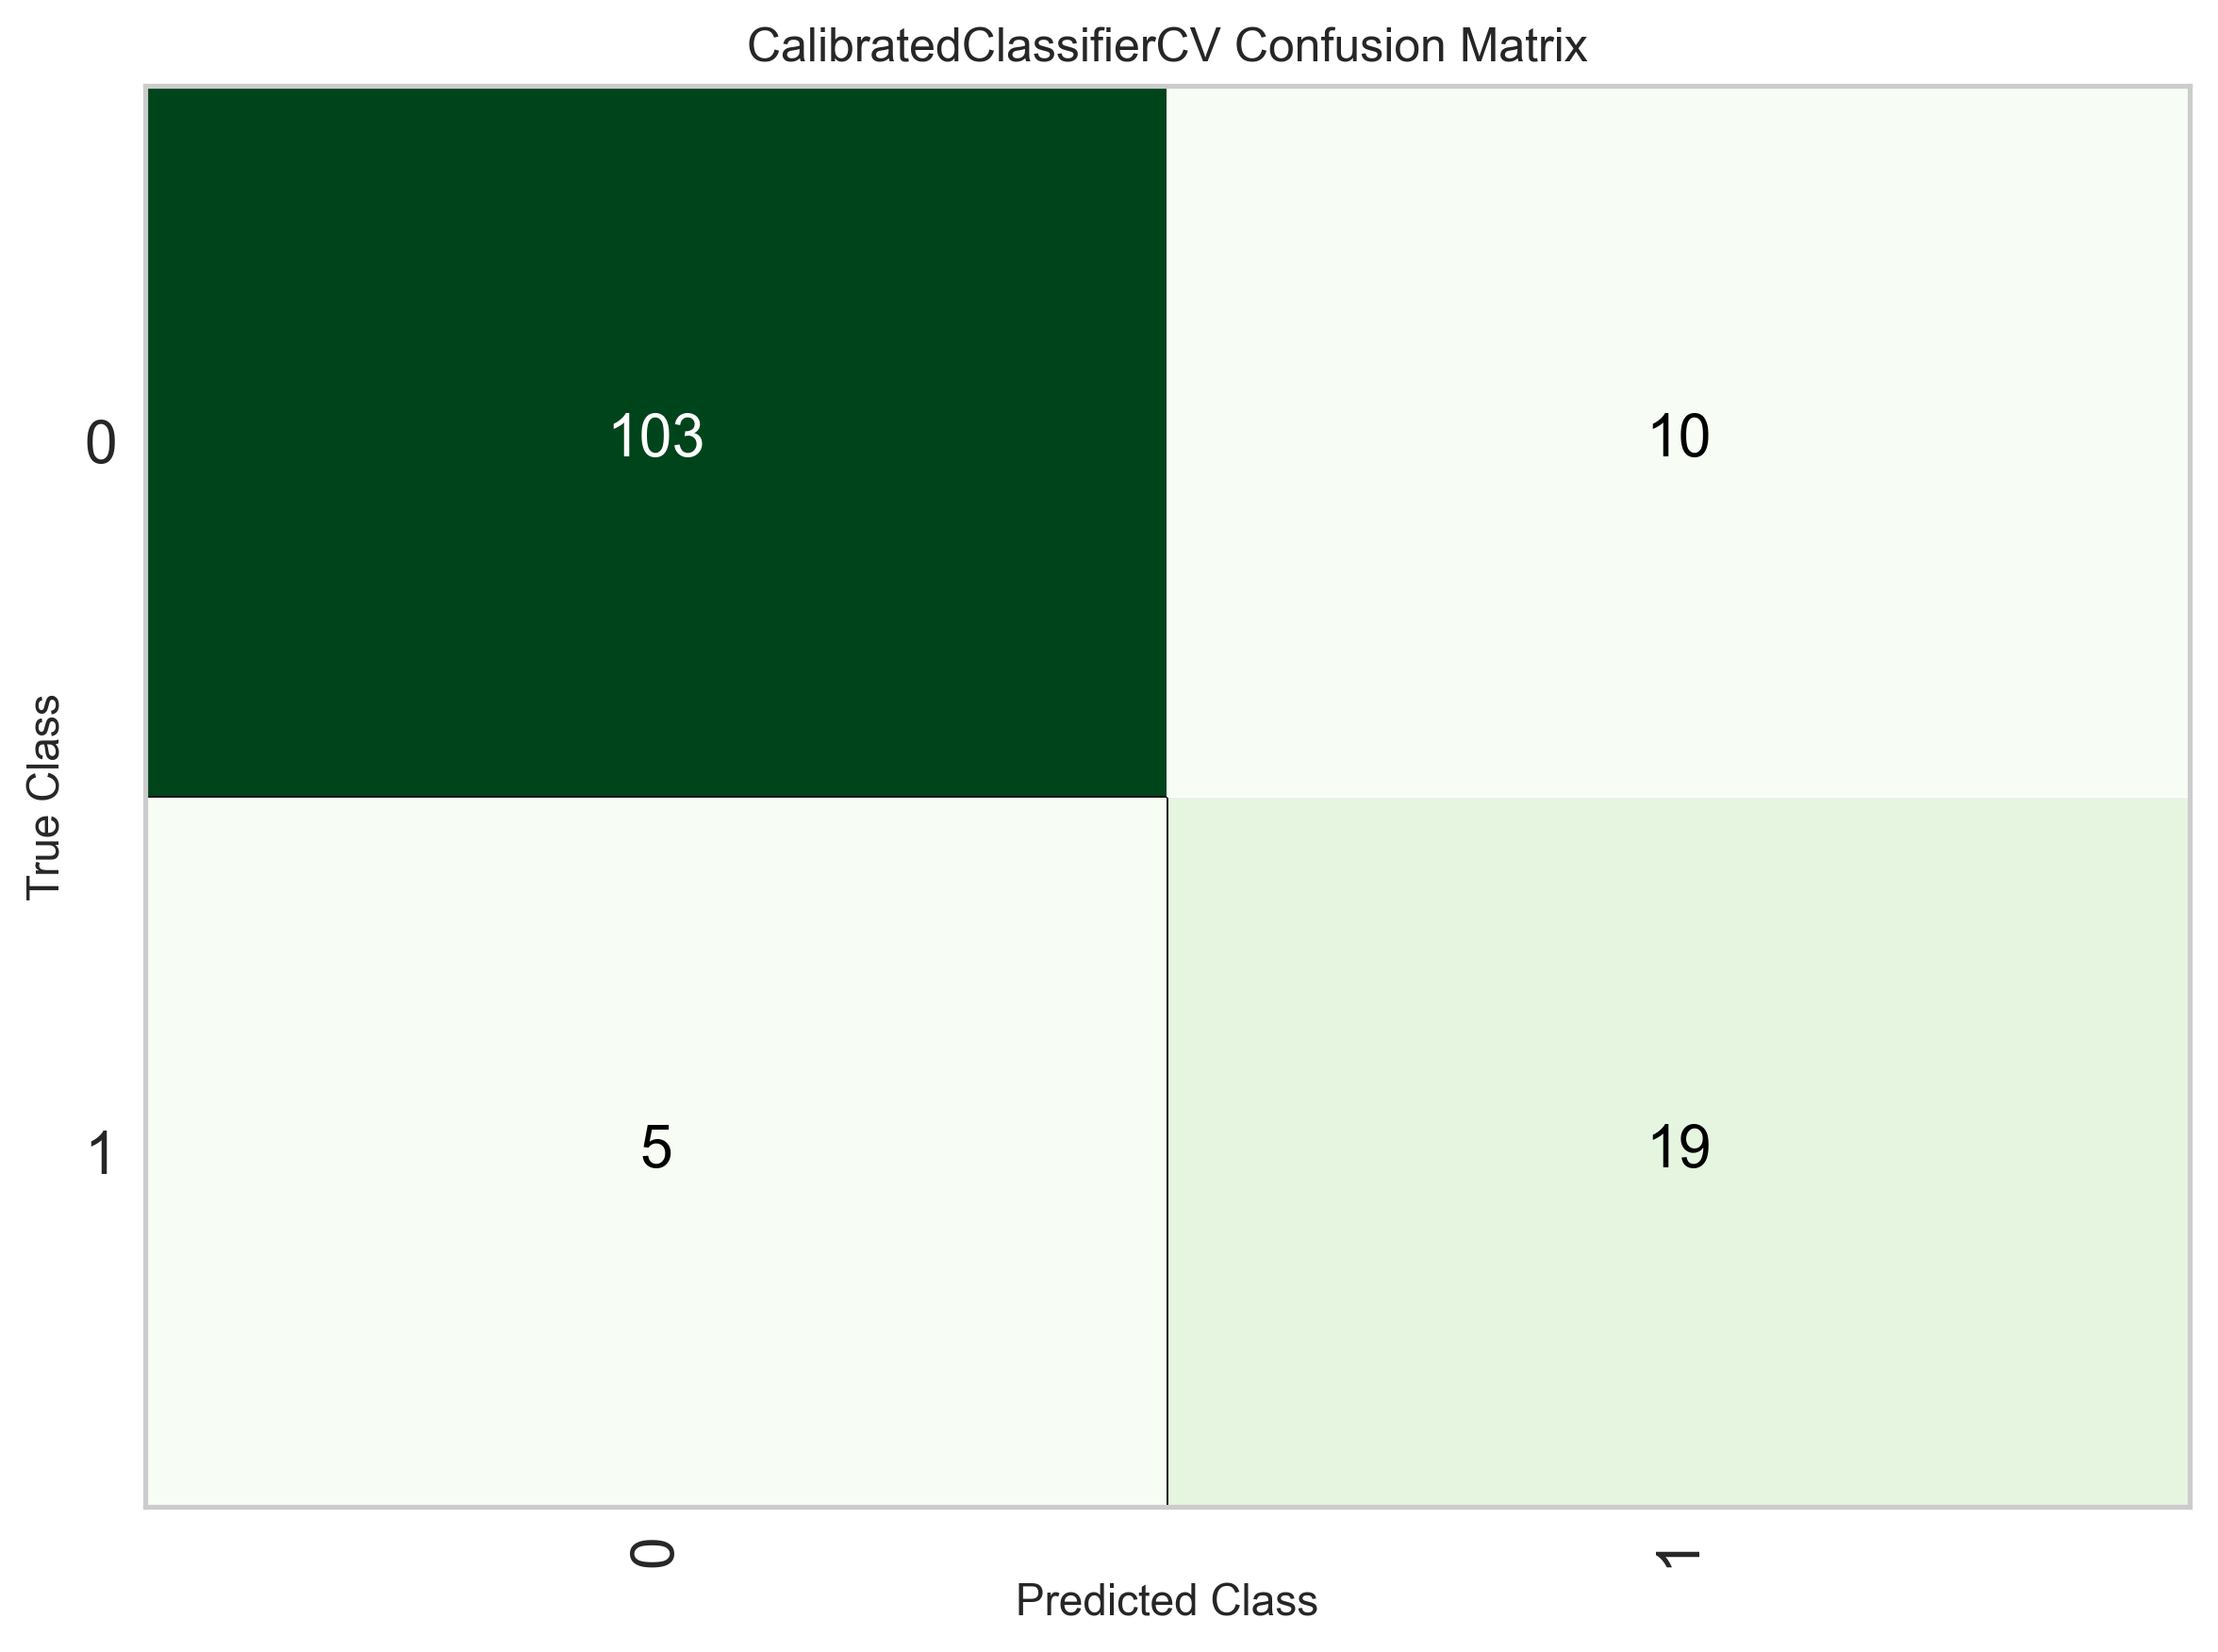

In [322]:
plt.figure(figsize=(8, 6),dpi=300)
plot_model(cali_model, plot = 'confusion_matrix')

In [133]:
cali_model = calibrate_model(stack_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9038,0.9526,0.9200,0.8846,0.9020,0.8077,0.8083
1,0.9423,0.9733,0.9200,0.9583,0.9388,0.8843,0.8849
2,0.9615,0.9956,1.0000,0.9259,0.9615,0.9232,0.9259
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9216,0.9800,0.9600,0.8889,0.9231,0.8433,0.8459
5,0.9412,0.9938,0.9600,0.9231,0.9412,0.8824,0.8831
6,0.9020,0.9800,0.9200,0.8846,0.9020,0.8040,0.8046
7,0.9216,0.9908,1.0000,0.8621,0.9259,0.8436,0.8541
8,0.9216,0.9954,0.8400,1.0000,0.9130,0.8426,0.8532


In [136]:
pred_cali = predict_model(cali_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8905,0.9539,0.7917,0.6552,0.7170,0.6499,0.6543


In [137]:
plot_model(stack_model,plot='calibration',save=True)

'Calibration Curve.png'

In [110]:
pred_stack=predict_model(stack_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8832,0.9384,0.6667,0.6667,0.6667,0.5959,0.5959


In [ ]:
final_model = finalize_model(stack_model)

# shap可解释性分析

In [35]:
import shap

In [124]:
X = train_df.iloc[:,1:]
y = train_df.iloc[:,0]

## 训练集的shap explainer

In [56]:
explainer3 = shap.Explainer(tuned_catboost)
shap_values =explainer3.shap_values(X, y)

In [125]:
X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

## 测试集的shap explainer

In [210]:
explainer4 = shap.Explainer(tuned_catboost)
shap_values2 =explainer4.shap_values(X_test, y_test)

## 全部的

In [215]:
combined_df = pd.concat([test_df, train_df], axis=0)

In [323]:
explainer5 = shap.Explainer(tuned_catboost)
shap_values4 =explainer5.shap_values(combined_df.iloc[:,1:], combined_df.iloc[:,0])

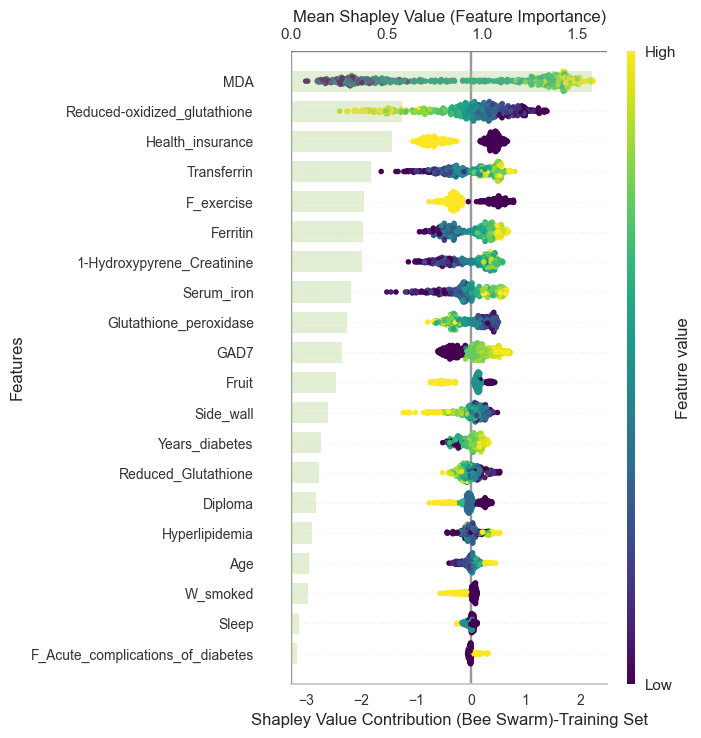

In [97]:
fig, ax1 = plt.subplots(figsize=(20, 20),dpi=100)
cmap = plt.get_cmap('viridis')  # 可选择不同的颜色映射，如 'viridis', 'plasma', 'inferno' 等

shap.summary_plot(shap_values, X, feature_names=X.columns,max_display = 20, plot_type="dot", show=False, color_bar=True,cmap=cmap)
plt.gca().set_position([0.5, 0.5, 0.6, 0.6])  
ax1 = plt.gca()
ax1.grid(False)

ax2 = ax1.twiny()
ax2.grid(False)
color ='#A0CB76'
shap.summary_plot(shap_values, X,feature_names=X.columns, max_display = 20,plot_type="bar", show=False,color=color)
plt.gca().set_position([0.5, 0.5, 0.6, 0.6])  
线
ax2.axhline(y=20, color='gray', linestyle='-', linewidth=1)  

bars = ax2.patches 
for bar in bars:
    bar.set_alpha(0.3)

ax1.set_xlabel('Shapley Value Contribution (Bee Swarm)-Training Set', fontsize=12)
ax2.set_xlabel('Mean Shapley Value (Feature Importance)', fontsize=12)
ax2.xaxis.set_label_position('top')  
ax2.xaxis.tick_top()  

ax1.tick_params(axis='both', which='major', labelsize=10) 
ax1.set_ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig("SHAP_combined_with_top_line_corrected-train.jpg", format='jpg', bbox_inches='tight')
plt.show()


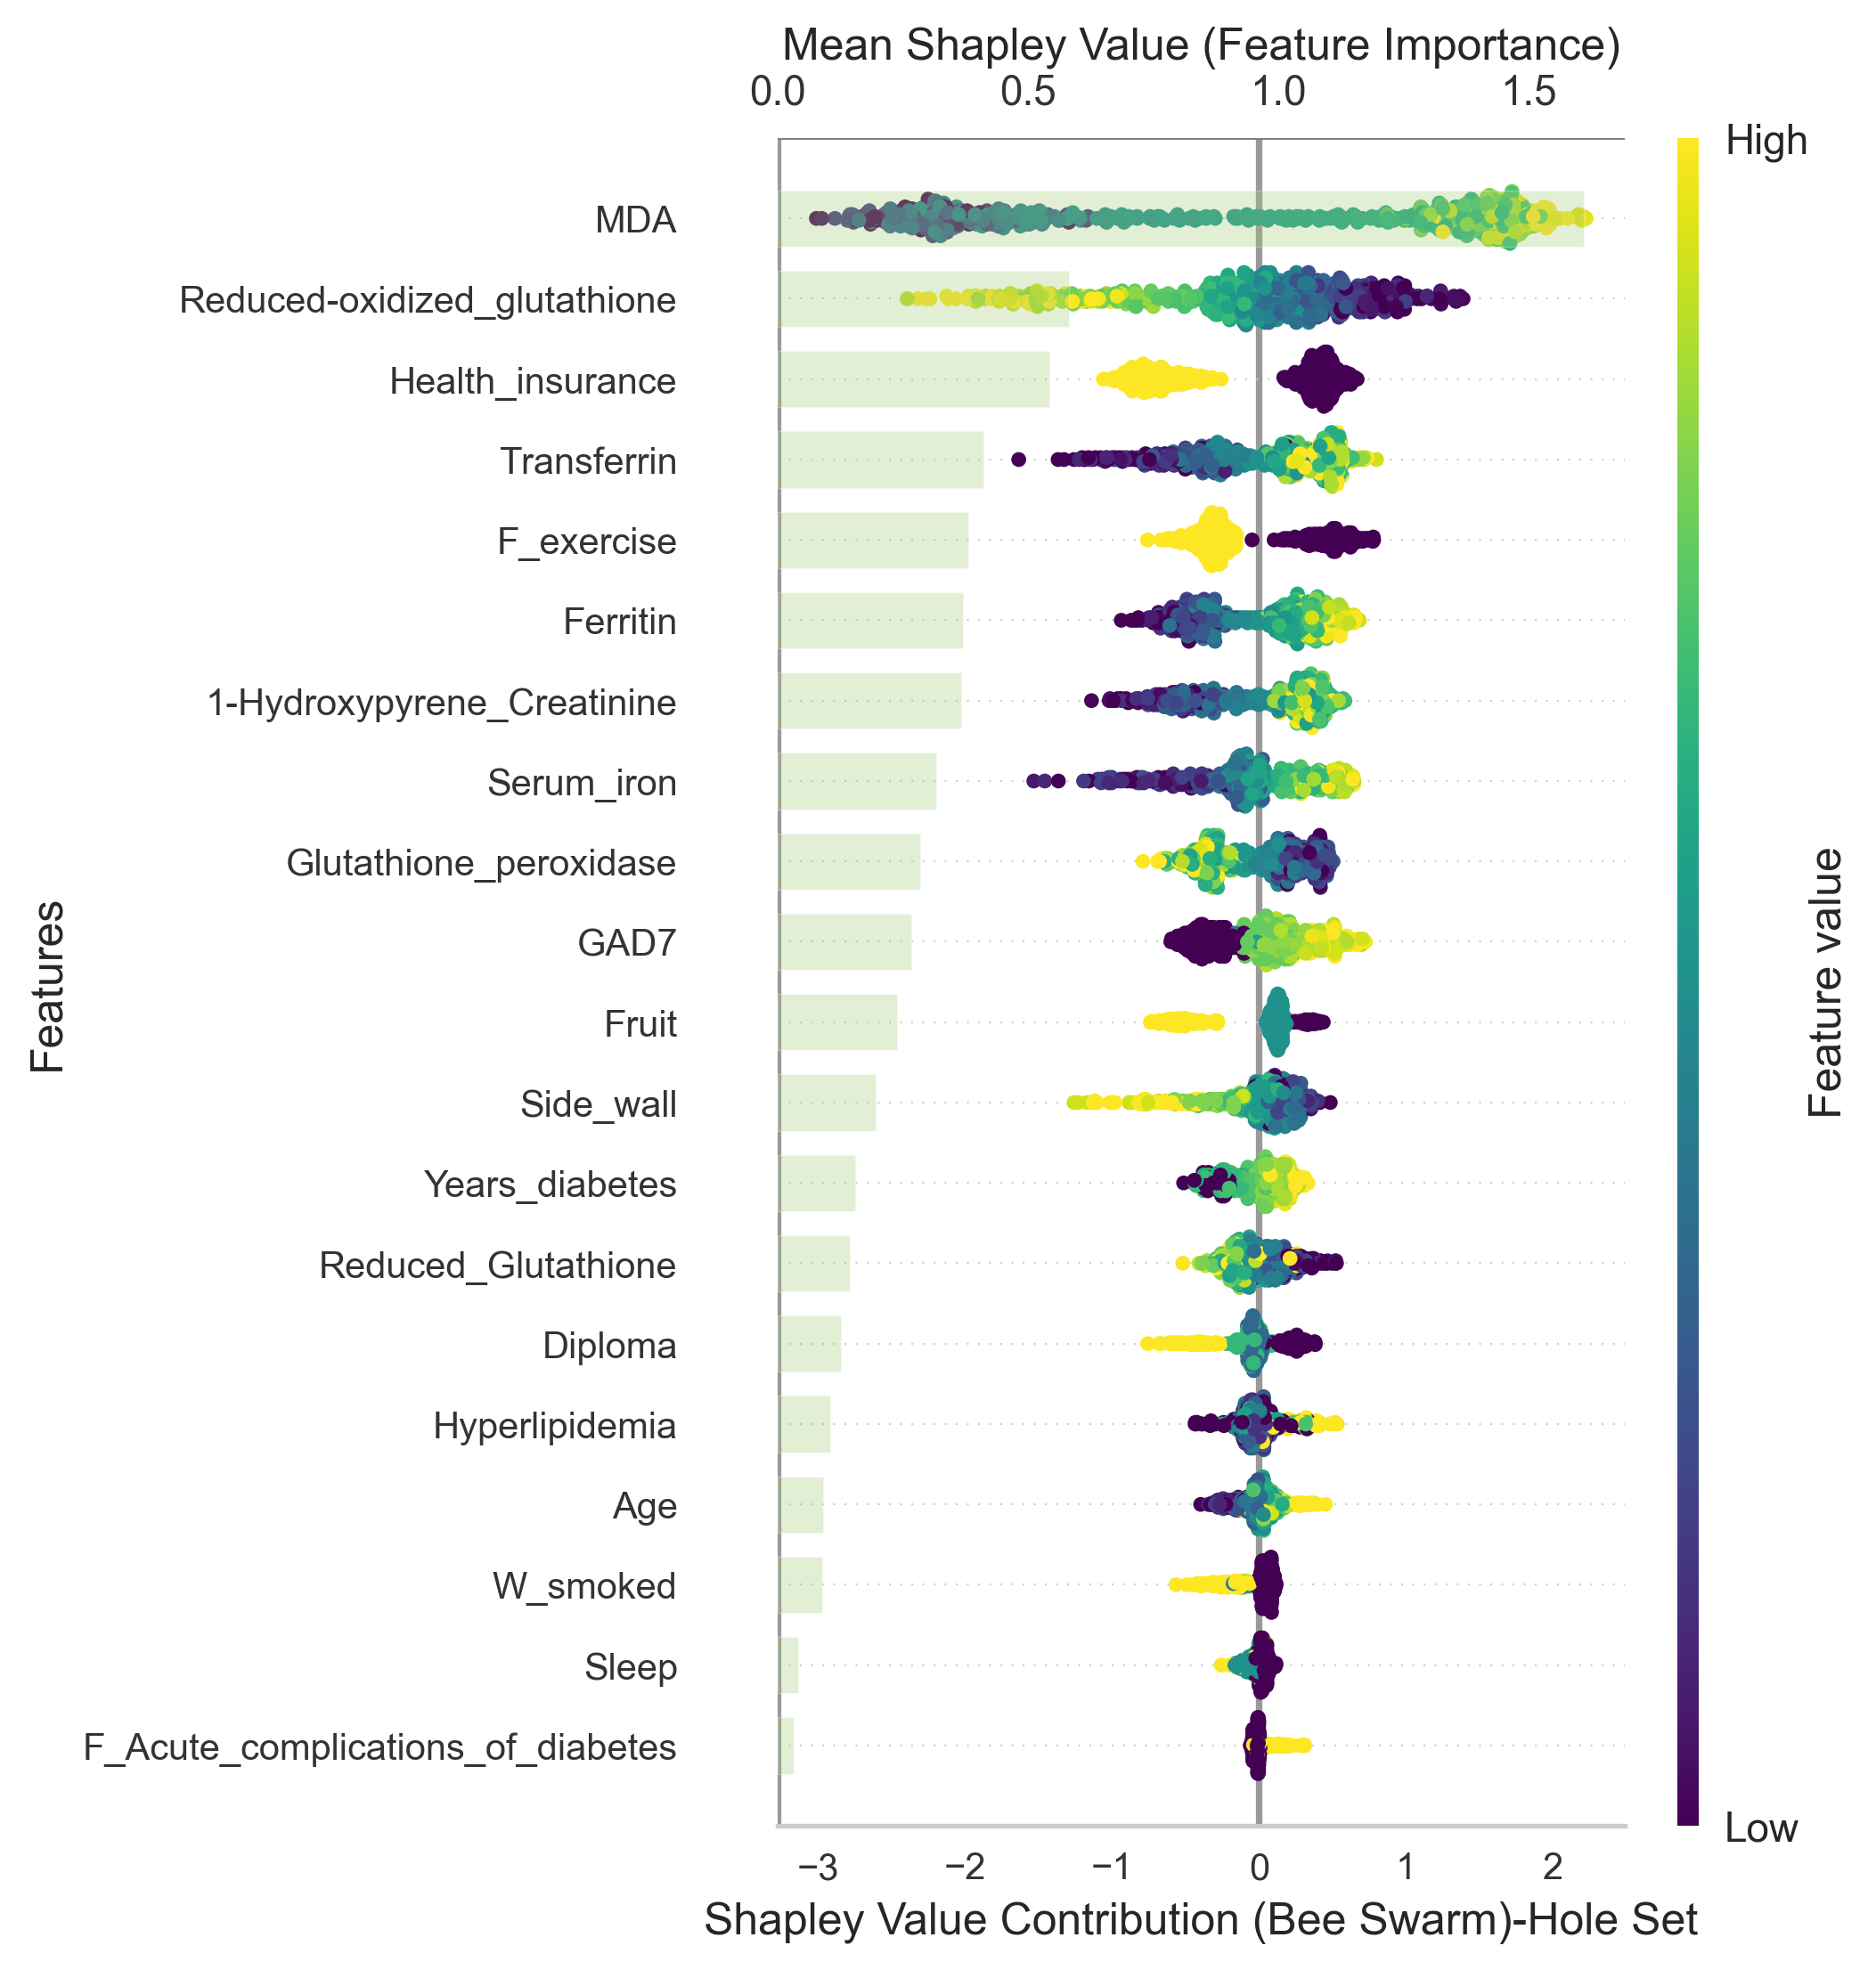

In [324]:
fig, ax1 = plt.subplots(figsize=(20, 20),dpi=300)
cmap = plt.get_cmap('viridis') 

shap.summary_plot(shap_values4, combined_df.iloc[:,1:], feature_names=combined_df.iloc[:,1:].columns,max_display = 20, plot_type="dot", show=False, color_bar=True,cmap=cmap)
plt.gca().set_position([0.5, 0.5, 0.6, 0.6]) 
ax1 = plt.gca()
ax1.grid(False)
ax2 = ax1.twiny()
ax2.grid(False)
color ='#A0CB76'
shap.summary_plot(shap_values4, combined_df.iloc[:,1:],feature_names=combined_df.iloc[:,1:].columns, max_display = 20,plot_type="bar", show=False,color=color)
plt.gca().set_position([0.5, 0.5, 0.6, 0.6])  

ax2.axhline(y=20, color='gray', linestyle='-', linewidth=1) 

bars = ax2.patches 
for bar in bars:
    bar.set_alpha(0.3)
ax1.set_xlabel('Shapley Value Contribution (Bee Swarm)-Hole Set', fontsize=12)
ax2.set_xlabel('Mean Shapley Value (Feature Importance)', fontsize=12)
ax2.xaxis.set_label_position('top')  #
ax2.xaxis.tick_top()  
ax1.tick_params(axis='both', which='major', labelsize=10) 
ax1.set_ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()


### 测试shap

In [326]:
explainer = shap.Explainer(tuned_catboost, combined_df.iloc[:,1:])
shap_values4 = explainer(combined_df.iloc[:,1:])

 96%|=================== | 628/651 [00:29<00:01]       

In [288]:
test_df.columns

Index(['MOCA_Grade', 'Health_insurance', 'F_exercise', 'Sleep', 'Fruit',
       'F_Suffering_from', 'F_Acute_complications_of_diabetes',
       'F_Hypoglycemia', 'W_Checked_inside_shoe', 'W_smoked',
       'PHQ9_Question_2', 'PHQ9_Question_5', 'PHQ9_Question_8', 'F_HbA1c',
       'Age', 'Years_diabetes', 'GAD7', 'Side_wall', 'Serum_iron', 'Ferritin',
       'Transferrin', 'Glutathione_peroxidase', 'MDA', 'Reduced_Glutathione',
       'Reduced-oxidized_glutathione', '1-Hydroxypyrene_Creatinine',
       'Hyperlipidemia', 'Diploma'],
      dtype='object')

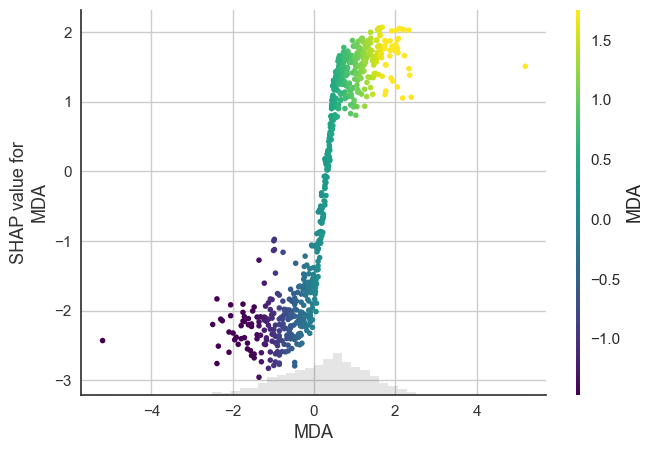

In [283]:
cmap = plt.get_cmap('viridis')
shap.plots.scatter(shap_values4[:, "MDA"],color=shap_values4[:, "MDA"], cmap="viridis")

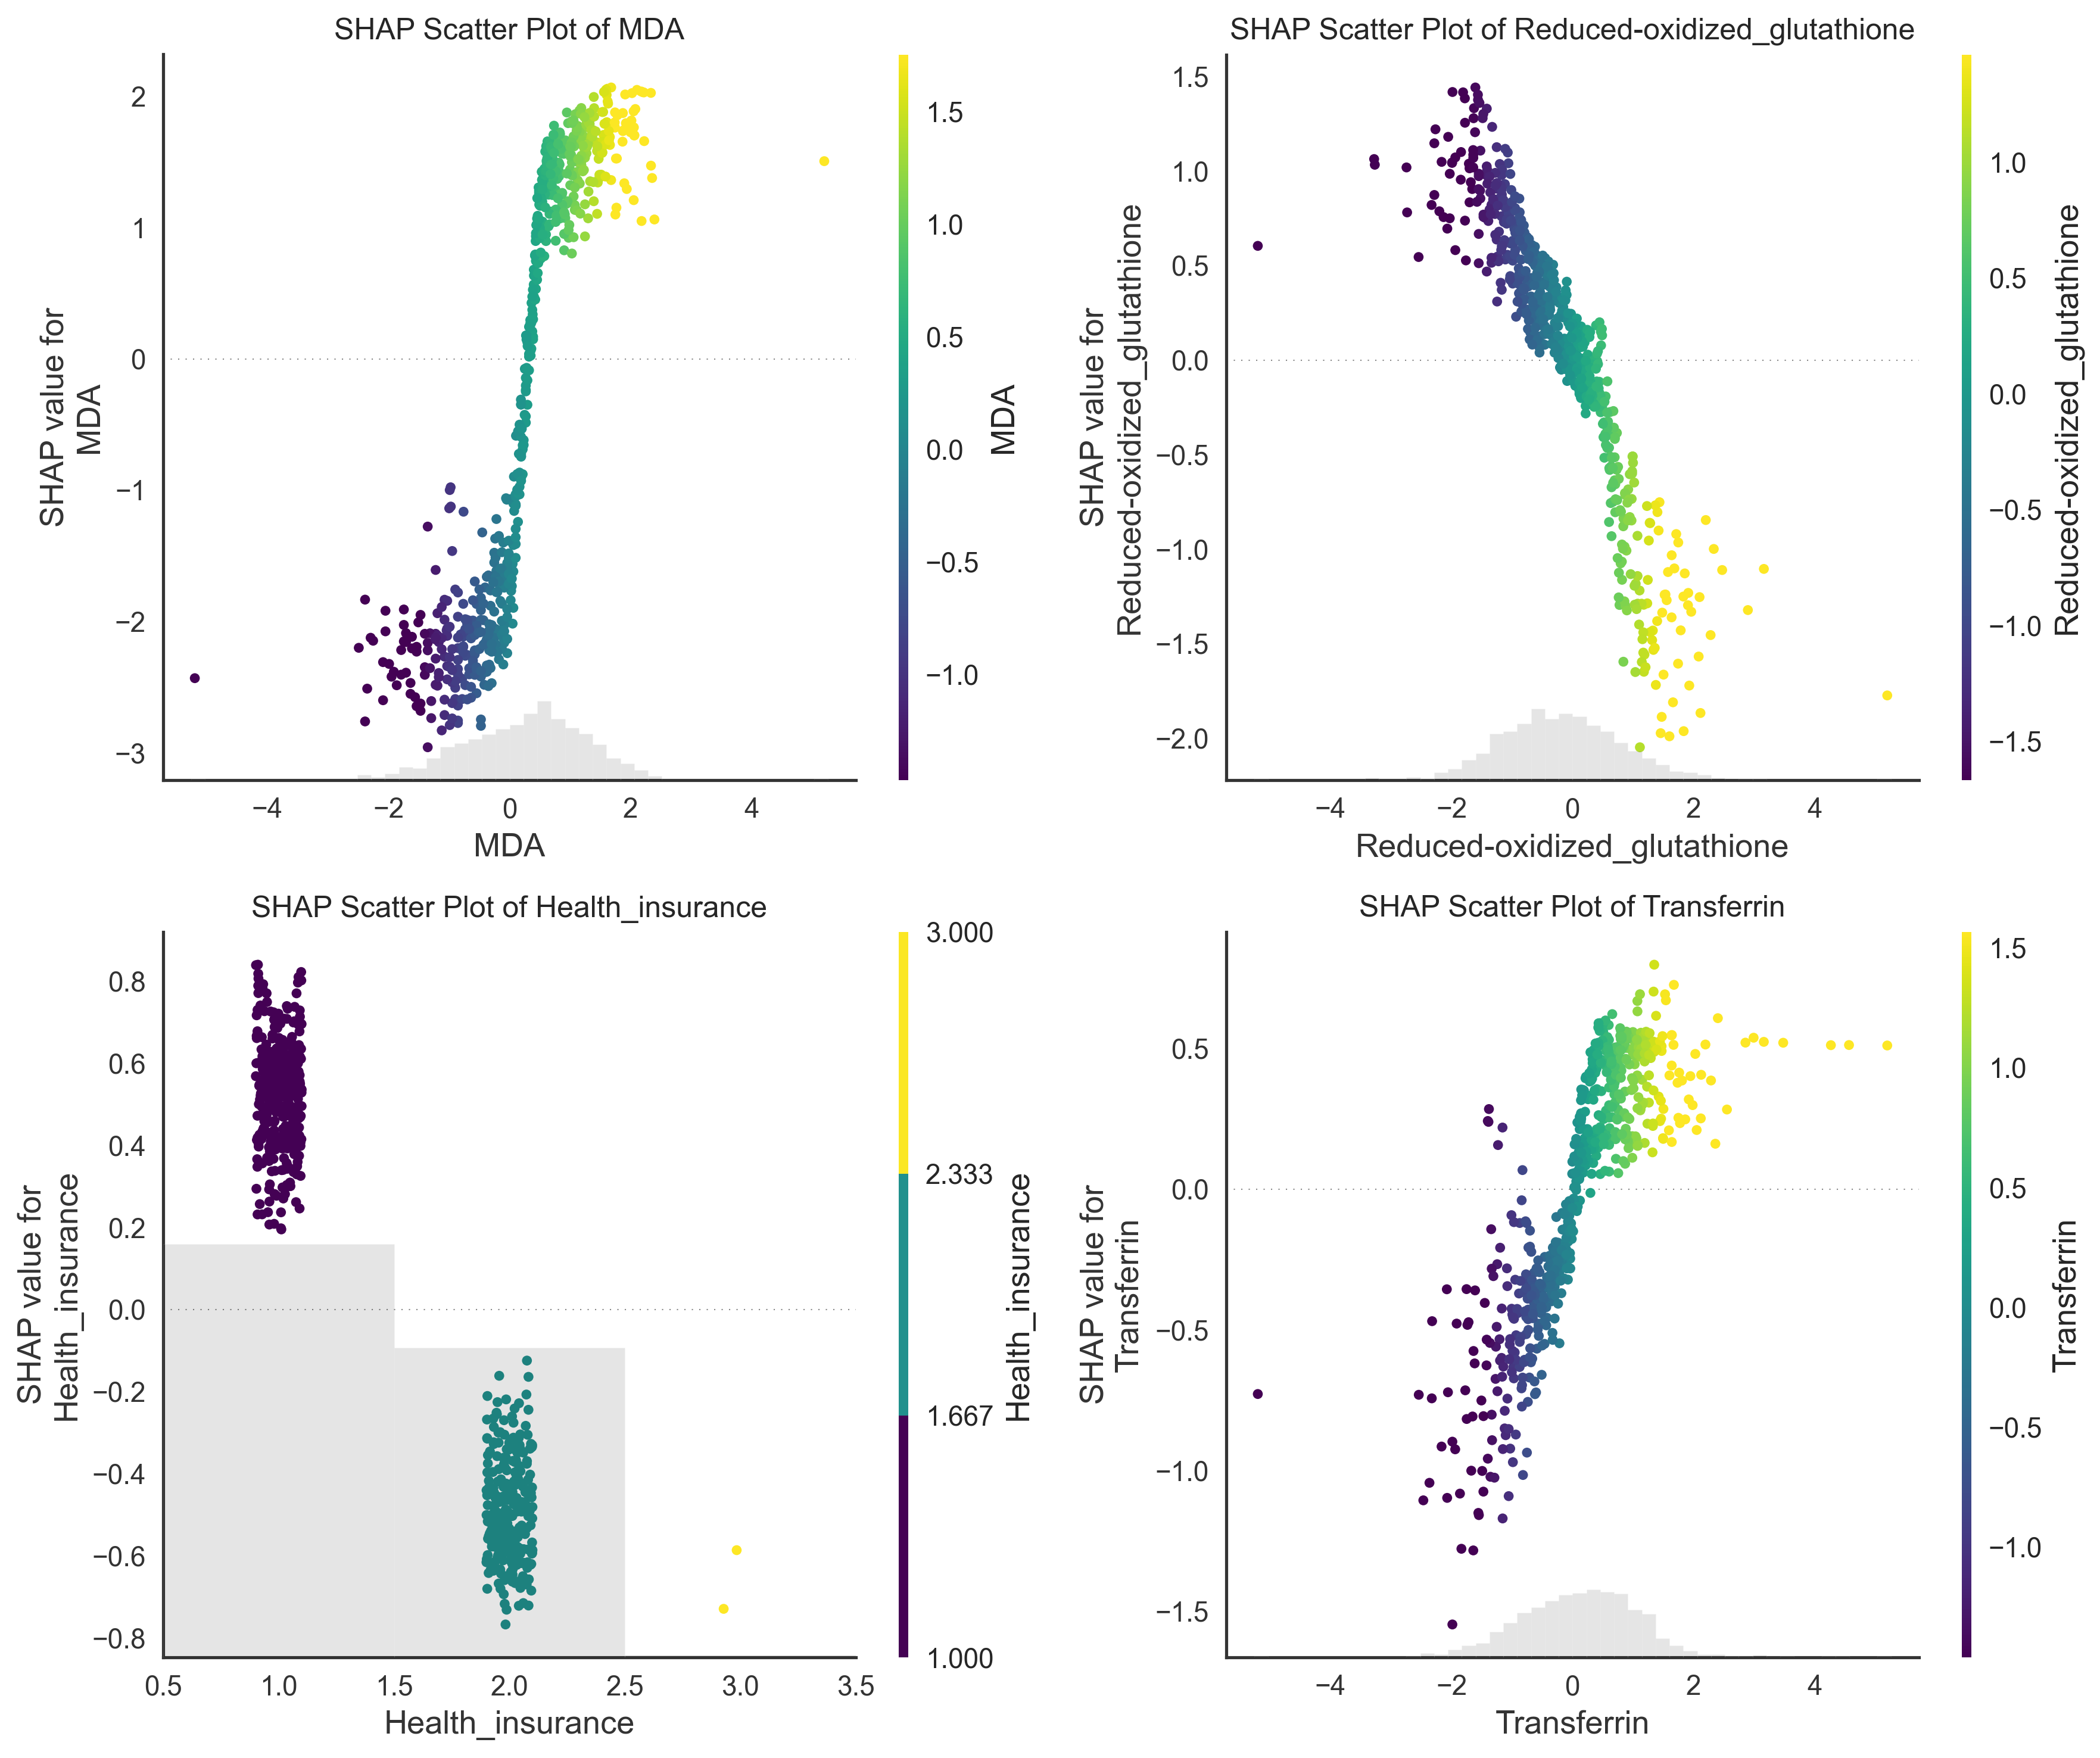

In [327]:
import shap
import matplotlib.pyplot as plt

cmap = plt.get_cmap('viridis')


fig, axs = plt.subplots(2, 2, figsize=(12,10),dpi=300)
variables = ["MDA", "Reduced-oxidized_glutathione", "Health_insurance", "Transferrin"]

for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    shap.plots.scatter(shap_values4[:, var], color=shap_values4[:, var], cmap=cmap, ax=axs[row, col],show=False,)
    axs[row, col].set_title(f"SHAP Scatter Plot of {var}")
    axs[row, col].grid(False)

plt.tight_layout()
plt.savefig("g", format='jpg', bbox_inches='tight')
plt.show()


##  测试集shap

In [314]:
explainer_t = shap.Explainer(tuned_catboost, test_df.iloc[:,1:])
shap_values_t = explainer_t(test_df.iloc[:,1:])

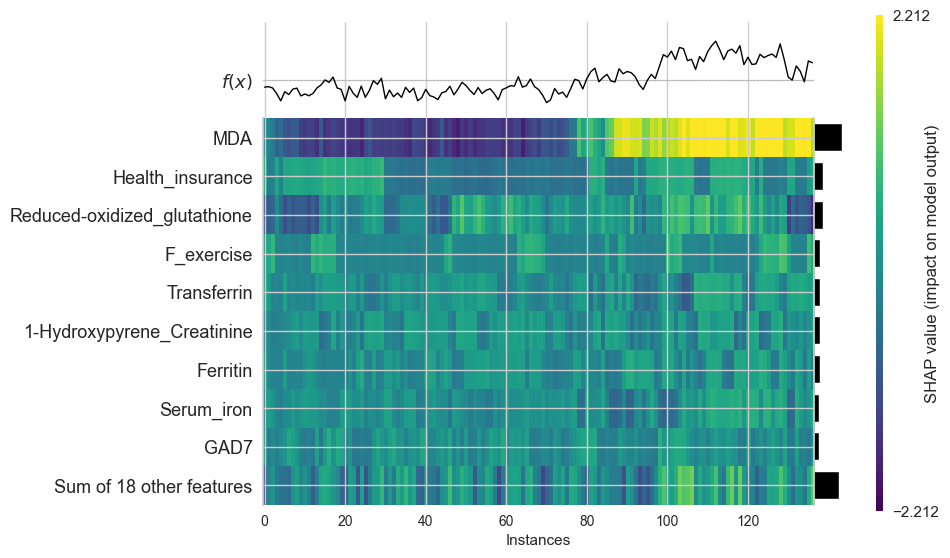

In [315]:
shap.plots.heatmap(shap_values_t ,cmap=cmap)

# 绘制ROC曲线

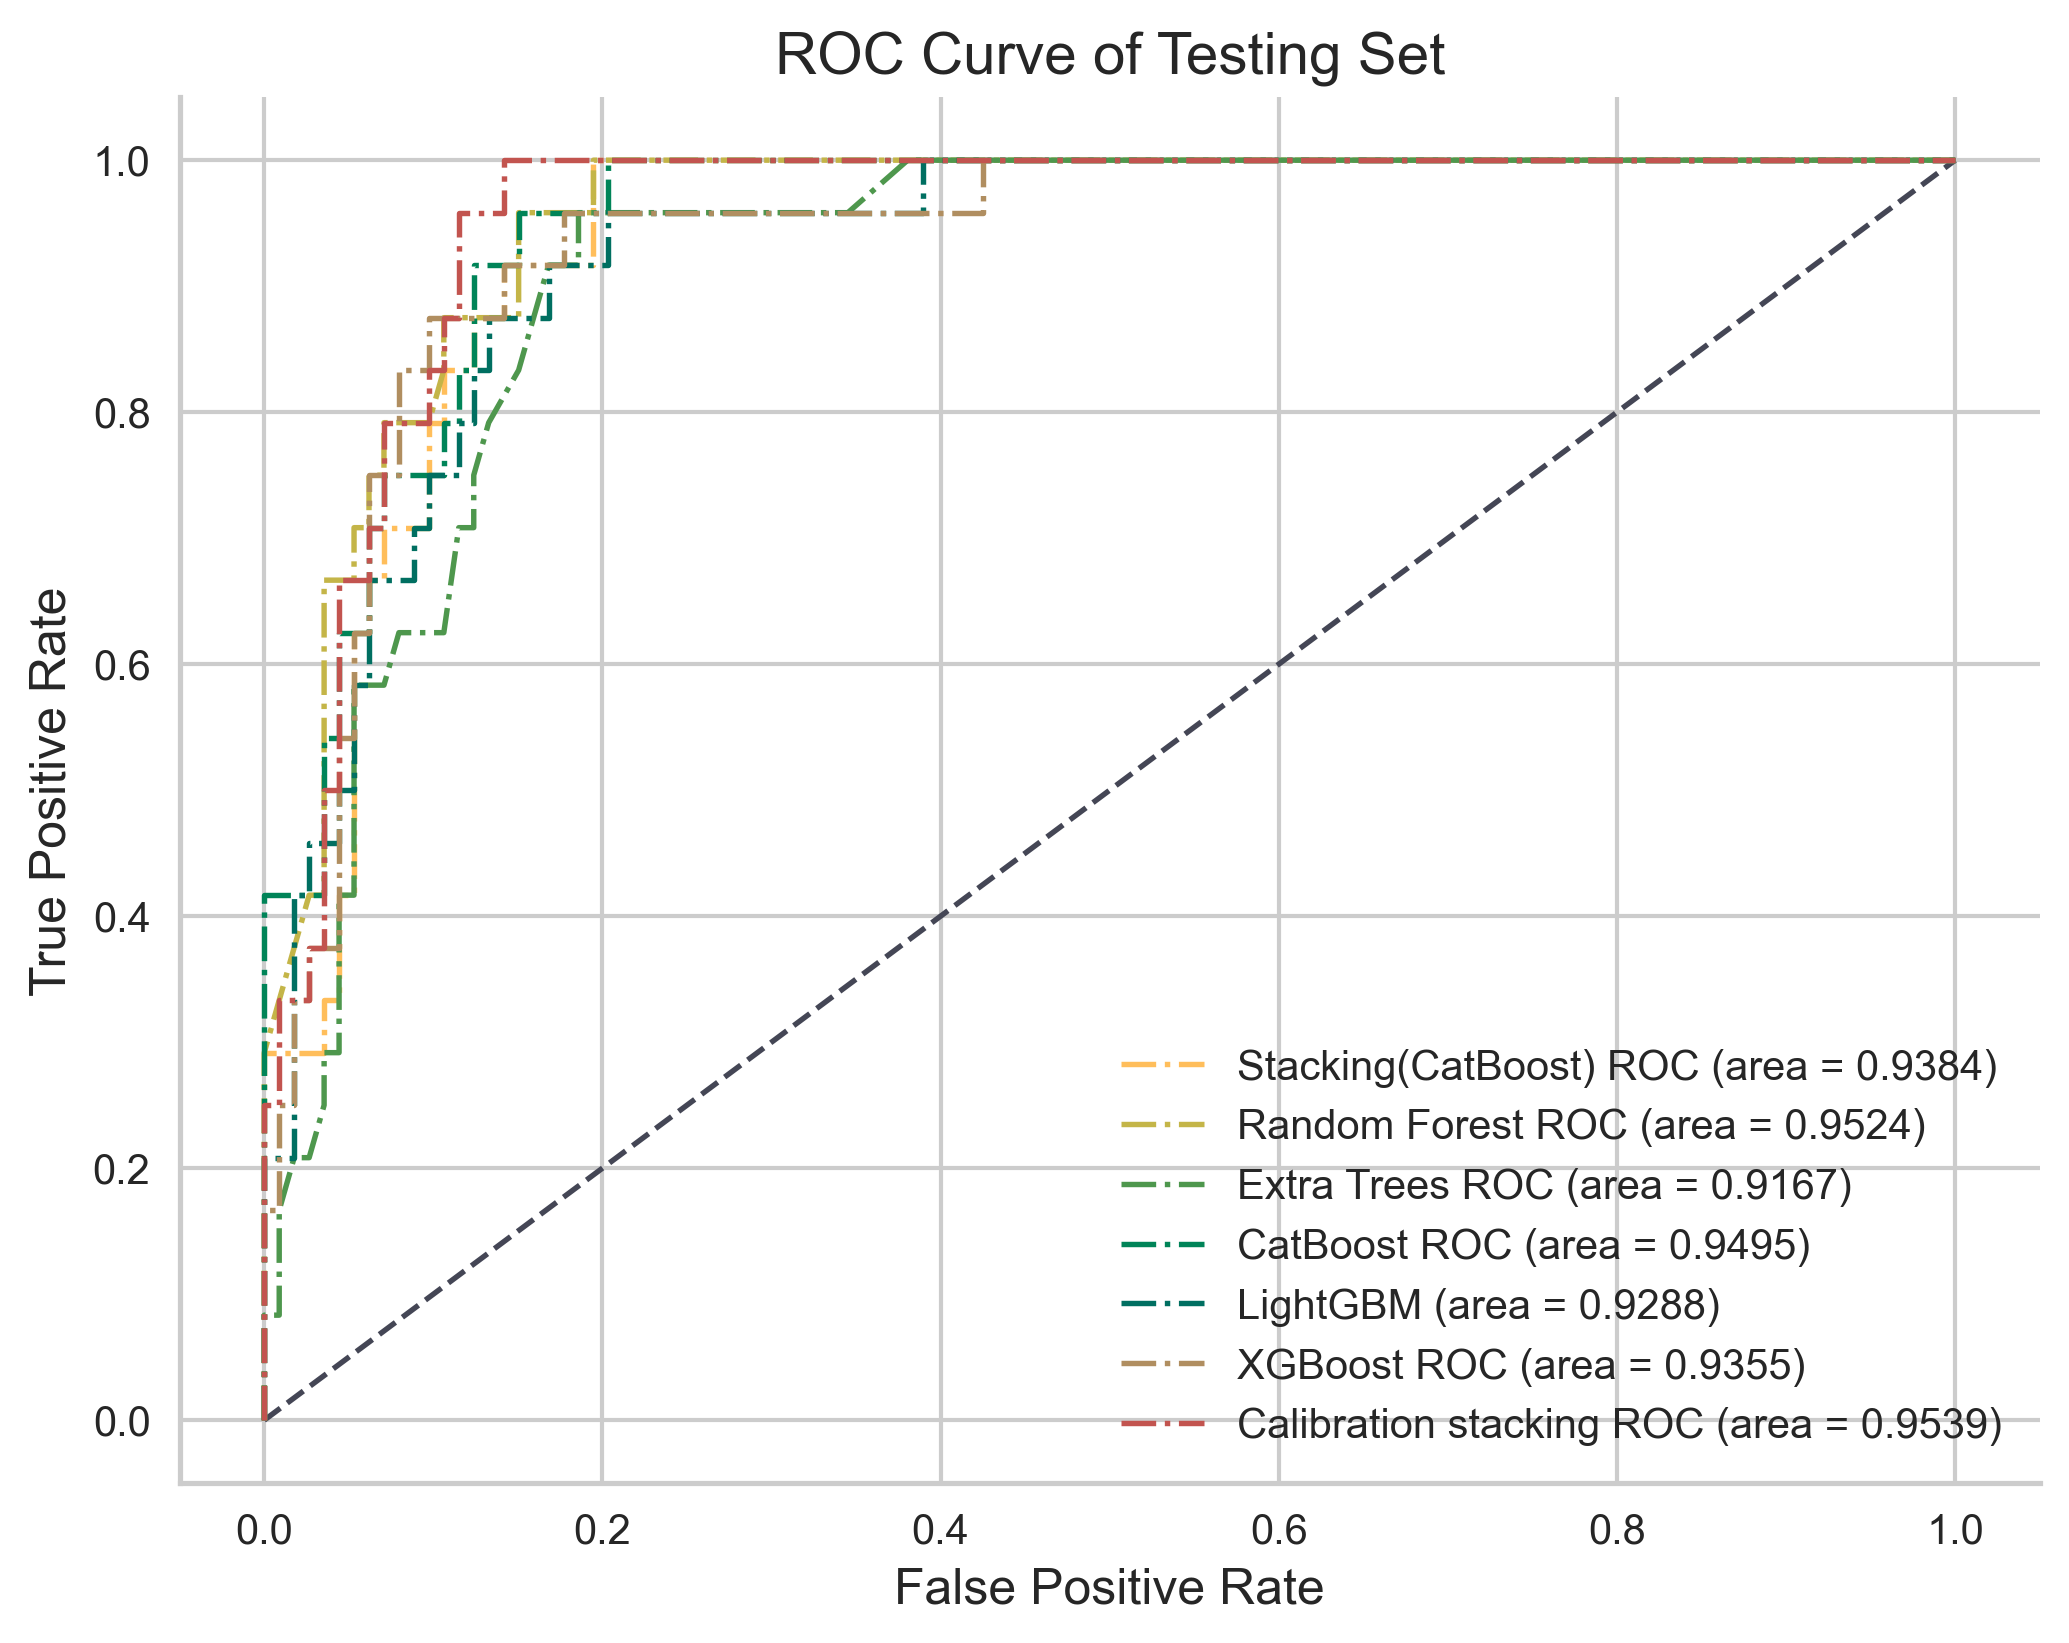

In [318]:
plt.figure(figsize=(8,6),facecolor='w',dpi=300)
lw = 1.3
plt.plot([0, 1], [0, 1], color='#444655', lw=lw, linestyle='--')  
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])  
for i in range(7):
    roc_auc=0
    if i==0:
        y_score =  stack_model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)  
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, color='#FFBE5B', lw=lw,linestyle='-.' ,label='Stacking(CatBoost) ROC (area = %0.4f)' % roc_auc)  
    if i==1:
        y_score =  tuned_rf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)  
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, color='#C4B548', lw=lw,linestyle='-.' ,label='Random Forest ROC (area = %0.4f)' % roc_auc)
    if i==2:
        y_score =  tuned_et.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)  
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, color='#4E974D', lw=lw,linestyle='-.' ,label='Extra Trees ROC (area = %0.4f)' % roc_auc)   
    if i==3:
        y_score =  tuned_catboost.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)  
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, color='#008458', lw=lw,linestyle='-.' ,label='CatBoost ROC (area = %0.4f)' % roc_auc)   
    if i==4:
        y_score =  tuned_lightgbm.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)  
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, color='#006F61', lw=lw,linestyle='-.' ,label='LightGBM (area = %0.4f)' % roc_auc)  
    if i==5:
        y_score =  tuned_xgboost.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)  
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, color='#B08E60', lw=lw,linestyle='-.' ,label='XGBoost ROC (area = %0.4f)' % roc_auc) 
    if i==6:
        y_score =  cali_model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)  
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, color='#C2544F', lw=lw,linestyle='-.' ,label='Calibration stacking ROC (area = %0.4f)' % roc_auc)  

    ax = plt.gca()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend(loc="lower right") 
    plt.xlabel('False Positive Rate',fontsize=12)  
    plt.ylabel('True Positive Rate',fontsize=12)  
    plt.title("ROC Curve of Testing Set",fontsize=14)
plt.savefig(r'')

In [140]:
from sklearn.calibration import calibration_curve

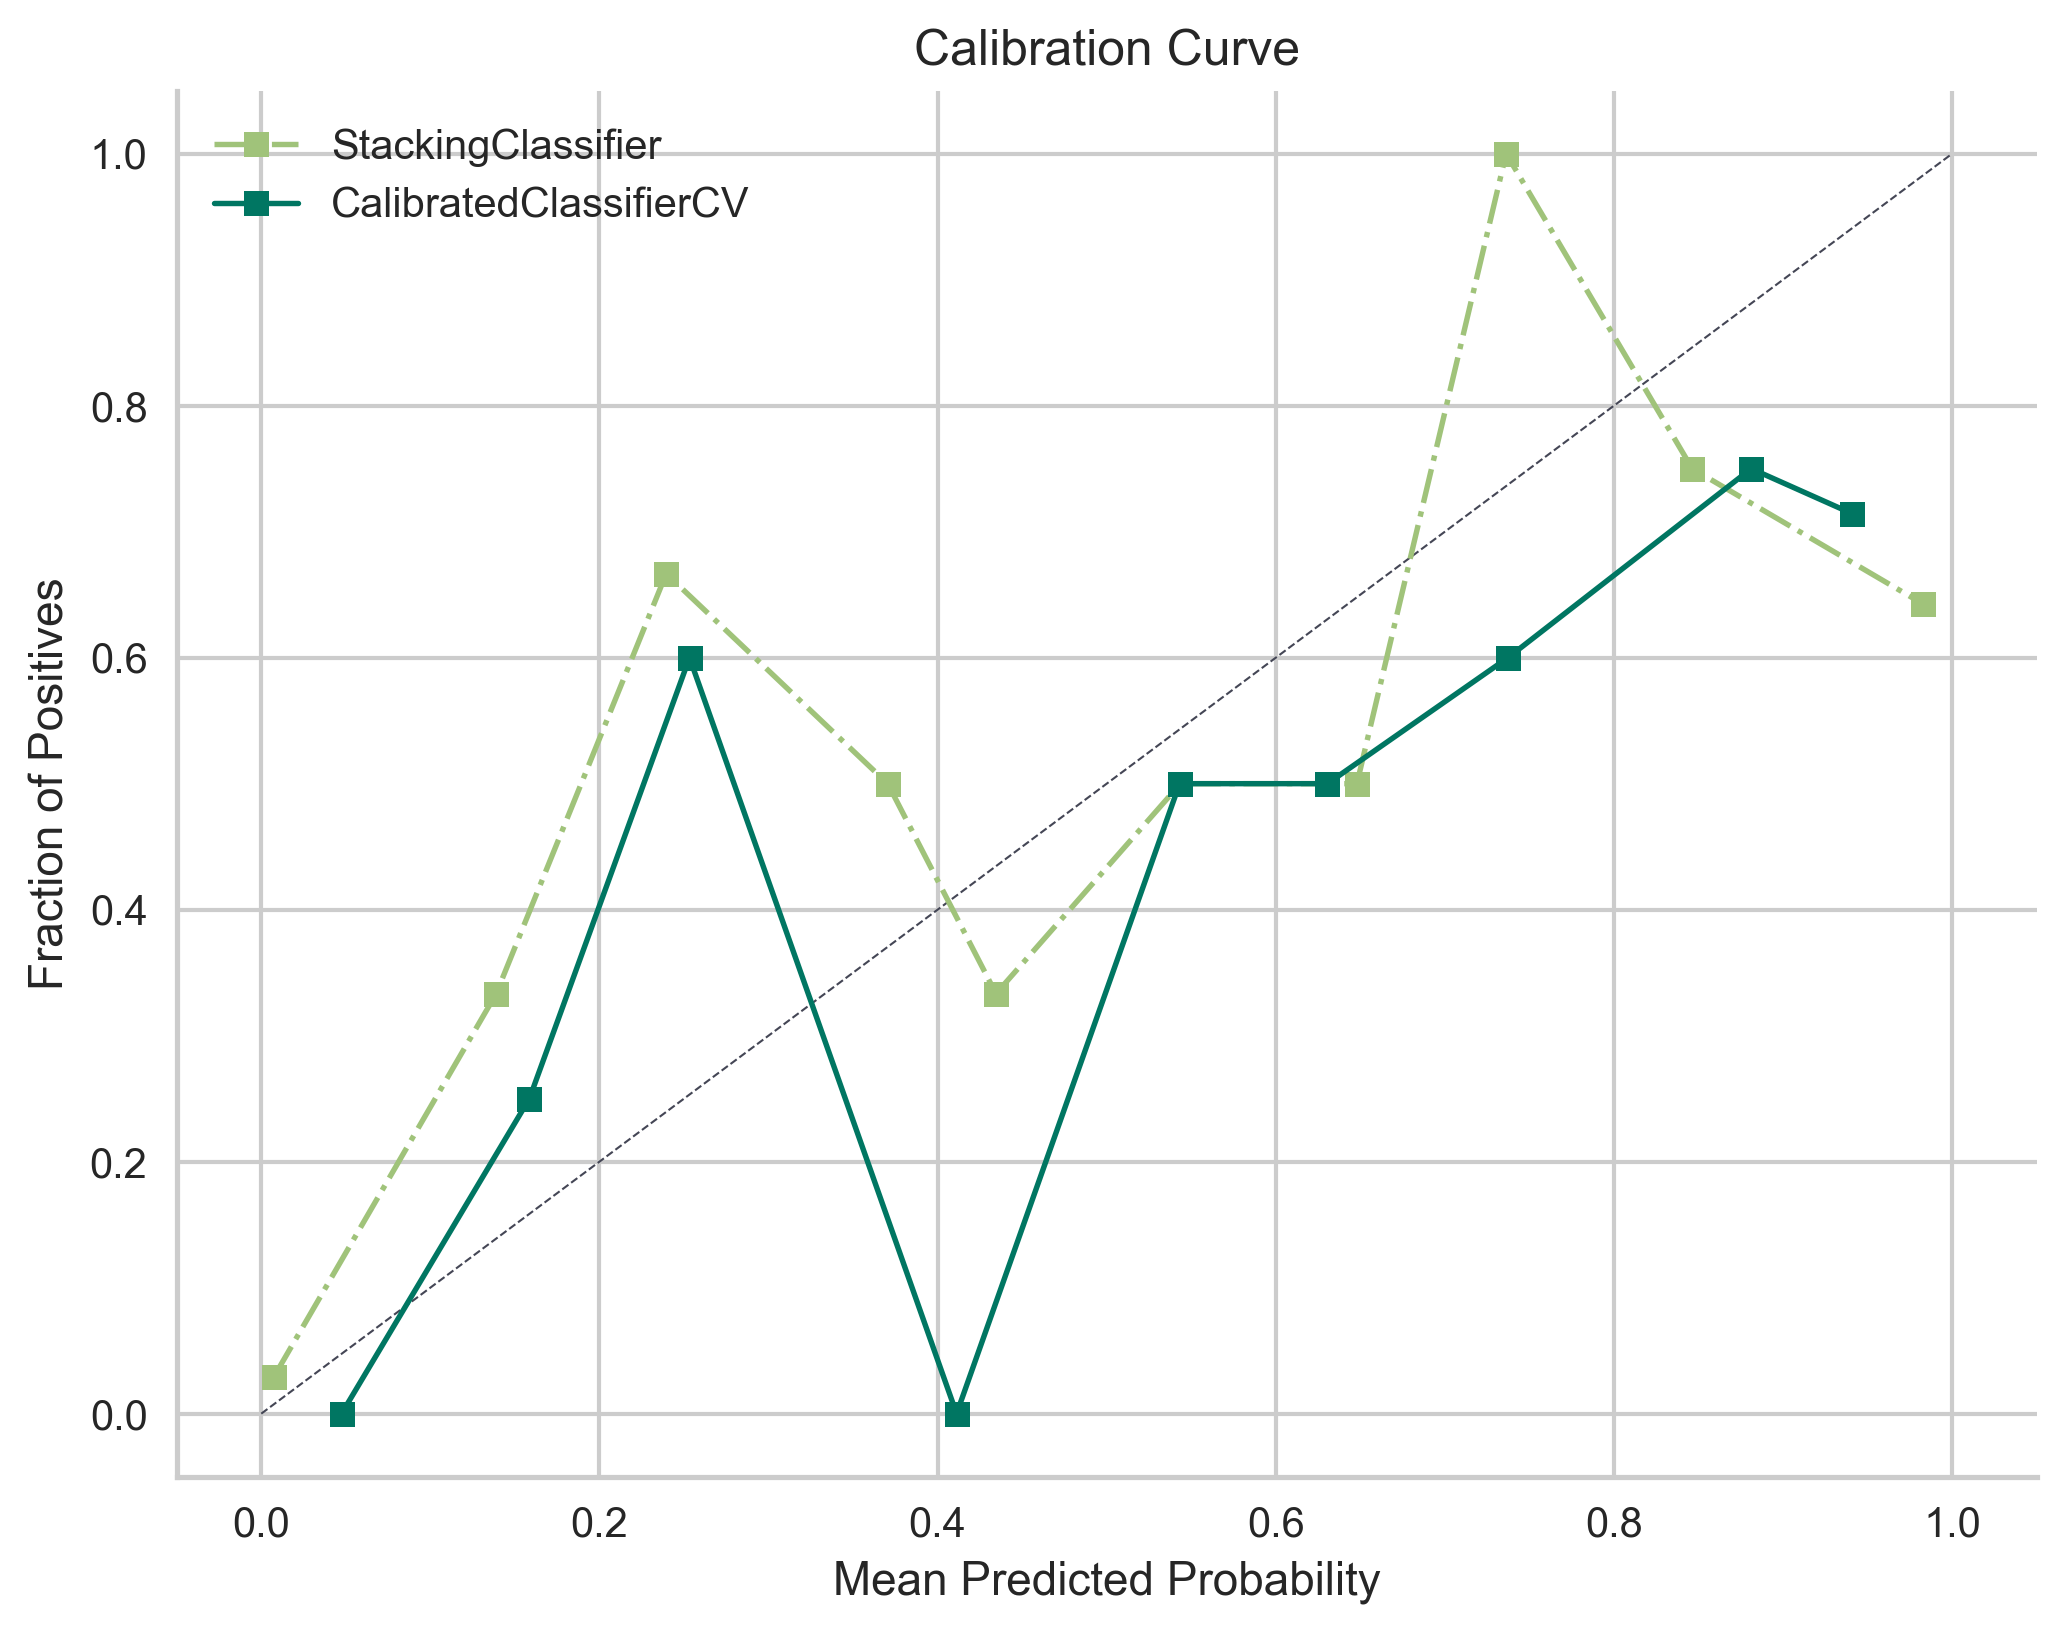

In [320]:
plt.figure(figsize=(8,6),facecolor='w',dpi=300)
lw = 0.5
plt.plot([0, 1], [0, 1], color='#444655', lw=lw, linestyle='--') 

models = [
    stack_model,
    tuned_rf,
    tuned_et,
    tuned_catboost,
    tuned_lightgbm,
    tuned_xgboost,
    cali_model,
]

calibration_data = []
colors = ['#FFBE5B','#00C794','#9AB0A7']
# 训练模型并计算校准曲线
for i,model in enumerate(models):
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    calibration_data.append((model.__class__.__name__, prob_true, prob_pred))

i=0
for model_name, prob_true, prob_pred in calibration_data:
    if i==0:
        plt.plot(prob_pred, prob_true, label=model_name,marker='s' ,markersize=6,color='#A0C37A',lw=1.3,linestyle='-.')
    if i==6:
        plt.plot(prob_pred, prob_true, label=model_name,marker='s',markersize=6,color='#007662',lw=1.3,linestyle='-')

    i=i+1

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.savefig(r'')


# 保存模型

In [ ]:
save_model(stack_model, './models/stack_model')

In [ ]:
save_model(calibrate_model, './models/saved_calibrate_model')